In [1]:
from IPython.display import HTML
HTML('''<script>
    code_show=true; 
    function code_toggle() {
        if (code_show){
         $('div.input').hide();
         } else {
         $('div.input').show();
         }
         code_show = !code_show
    } 
    $( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Primer on Three of the Most Popular Machine Learning Classifiers

Author: Greg Strabel
    
This notebook is a primer on three of the most popular machine learning algorithms for classification problems:
    1. Logistic Regression with L2 penalization
    2. Gradient Boosting Machine Classifier
    3. Feed Forward Neural Network
I first generate a dataset suitable for classification using the dataGeneratorClass module posted on my GitHub page. This dataset is built to be similar to those encountered in the insurance industry with a mix of categorical and continuous variables. For each of the machine learning algorithms, I give a brief introduction and then fit the model to the data.

In [2]:
# import Python packages, modules and functions

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataGeneratorClass import dataGenerator, plotData # this module is on my GitHub page
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss
import warnings
from importlib import reload
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',500)
pd.set_option('display.max_colwidth', -1)
def pretty_df(df, n = 10):
    return df.head(n).style.set_properties(**{'text-align': 'center',
                            'white-space': 'nowrap'})

In [3]:
# Generate data

catg_lvls = [5, 8, 3] # 3 categorical variables with corresponding # of levels
n_cat = len(catg_lvls)
n_beta = 2 # number of beta variables
n_uniform = 1 # of uniform variables
n = n_cat + n_beta + n_uniform
N = 120000 # number of observations
responseMean = 0.5 # Bernoulli response mean
p_width = 1
np.random.seed(123)
trainPercent = 2./3 # fraction of data for training
testPercent = 1./6 # fraction of data for test
Ntrain = int(N * trainPercent);
Ntest = int(N * testPercent)

# Generate data
x = dataGenerator(catg_lvls = catg_lvls, n_beta = n_beta, n_uniform = n_uniform)
df1, df2 = x.generate(1000)
f = x.genSigmoidTransform(df2, loc = responseMean, width = p_width)
df1, df2 = x.generate_more(N)
df = pd.concat([df1,pd.DataFrame(x.genBernoulliVariates(df2,f),columns=['Response'])],axis=1)

# Split data into train, test and validate
train, test, validate = df[:Ntrain], df[Ntrain:Ntrain+Ntest], df[Ntrain+Ntest:]

# Construct one-hot-encodings for the categorical variables
X_train = pd.get_dummies(train[x.featureNames], prefix_sep = ' Level : ')
Y_train = train.Response
# Scale the continuous variables to have mean zero and standard deviation of one.
# Retain the scaler object to apply to test and validation
scaler = preprocessing.StandardScaler().fit(X_train.loc[:,x.cont_cols].values)
X_train_scaled = X_train.copy()
X_train_scaled.loc[:,x.cont_cols] = (scaler.transform(X_train.loc[:,
            x.cont_cols].values))
X_test = pd.get_dummies(test[x.featureNames], prefix_sep=' Level : ')
X_test_scaled = X_test.copy()
X_test_scaled.loc[:,x.cont_cols] = (scaler.transform(X_test.loc[:,
            x.cont_cols].values))
Y_test = test.Response
X_validate = pd.get_dummies(validate[x.featureNames], prefix_sep=' Level : ')
X_validate_scaled = X_validate.copy()
X_validate_scaled.loc[:,x.cont_cols] = (scaler.transform(X_validate.loc[:,
            x.cont_cols].values))
Y_validate = validate.Response

To get a sense for the data, I plot histograms for each of the features (grey bars) along with the response means for the given bucket (orange lines). The first three features are unordered categorical variables, while the final three features are continuous. It is important to emphasize that, although I use numbers to label the levels of the categorical variables, these variables are not numeric and have no natural ordering. As an example, imagine that U.S. states are a categorical variable and that rather than use the states' names or abbreviations as the level labels, we assign state codes 1 through 50. We would not treat the order of these numbers as meaningful and would certainly not attempt to fit a line or curve to this variable directly.

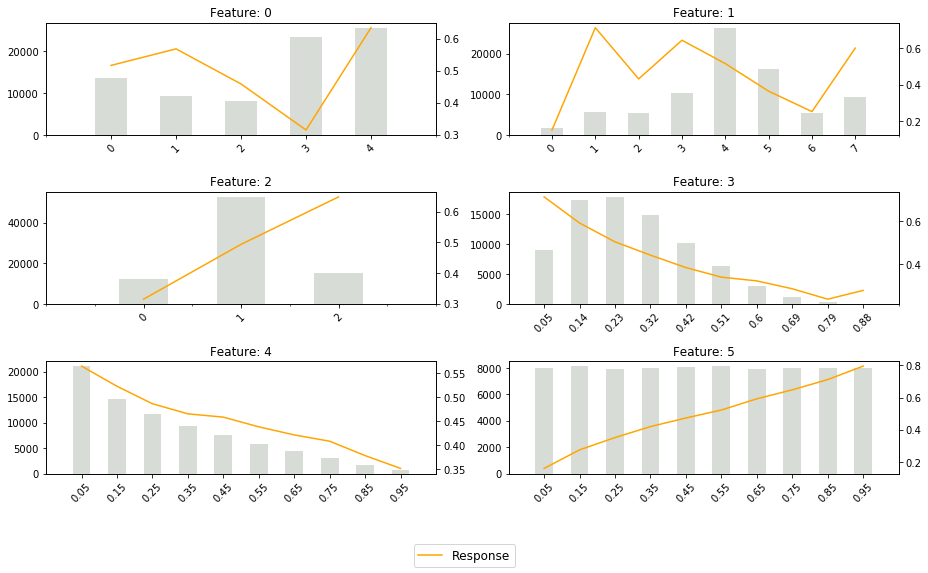

In [4]:
plotData(train, response = 'Response')

Before proceeding, two observations are in order.

First, in machine learning and statistical analysis more generally, it is a best practice to partition one's data into 2 to 3 subsets: a training dataset, a test dataset and a validation dataset. The training dataset is used to make preprocessing decisions (grouping/binning, scaling and centering, applying transformations such as natural logarithms, etc.) as well as fitting the model directly. If the model being used requires tuning (for instance, selecting hyperparameters) the test set is used for making these decisions. Finally, the validation dataset is used to perform a final check of the predictive power of the model as well as for objective comparisons of different models. Of course, these are not hard and fast rules and, depending on the situation, a modified approach may be required and justifiable.

Second, most machine learning algorithms cannot use unordered categorical variables directly; they expect all variables to be numeric. As a result, the most common method of dealing with categorical variables in machine learning is to one-hot-encode the variables. One-hot-encoding is the process of creating one new variable for each level of a categorical variable which is a 1-0 indicator for whether the categorical variable for a given observation takes on the given level.

For instance, observations of 'Feature: 0' appear as:

In [5]:
pretty_df(train.loc[:,['Feature: 0']])

,Feature: 0
0,1
1,4
2,3
3,4
4,4
5,3
6,0
7,3
8,1
9,4


However, the machine learning algorithms below will be fed a one-hot-encoded version of 'Feature: 0':

In [6]:
pretty_df(X_train[[i for i in X_train.columns.tolist() if i.find('Feature: 0') != -1]])

,Feature: 0 Level : 0,Feature: 0 Level : 1,Feature: 0 Level : 2,Feature: 0 Level : 3,Feature: 0 Level : 4
0,0,1,0,0,0
1,0,0,0,0,1
2,0,0,0,1,0
3,0,0,0,0,1
4,0,0,0,0,1
5,0,0,0,1,0
6,1,0,0,0,0
7,0,0,0,1,0
8,0,1,0,0,0
9,0,0,0,0,1


### Penalized Logistic Regression

The first machine learning classifier we will consider is classic logistic regression. Logistic regression models are one of the most popular classifiers for 2-class problems (i.e. classification problems having 2 classes; logistic regression models can be extended to 3+ class problems). As such, logistic regression is a good benchmark for comparison to other machine learning classifiers.

With two classes, labeled 0 and 1, logistic regression models the probability of an observation with features $X$ being of class 1 as $$\frac{1}{1 + e^{-\beta \cdot X}}$$

Logistic regression solves for the value of $\beta$ that minimizes the empirical loss function: $$\sum\limits_{i=1}^N \left[ \left( 1-y_i \right) \cdot \beta \cdot x_i + \ln \left( 1 + e^{-\beta \cdot x_i} \right) \right]$$

To prevent overfitting the model, a penalization term is often added to the empirical loss function that 'shrinks' the parameters in $\beta$ back to zero. Lasso, ridge and elastic net regression are the most common forms of penalization. Here we will use ridge regression penalization and estimate the penalization tuning parameter using cross validation.

In [7]:
from sklearn.linear_model import LogisticRegressionCV
L2_LogisticRegression = LogisticRegressionCV(penalty='l2', tol=0.01)
L2_LogisticRegression.fit(X_train_scaled.values, Y_train.values)
L2_LogisticRegression_preds = L2_LogisticRegression.predict_proba(X_test_scaled.values)

I replicate the plots above using the test data and including the mean prediction from the Logistic Regression:

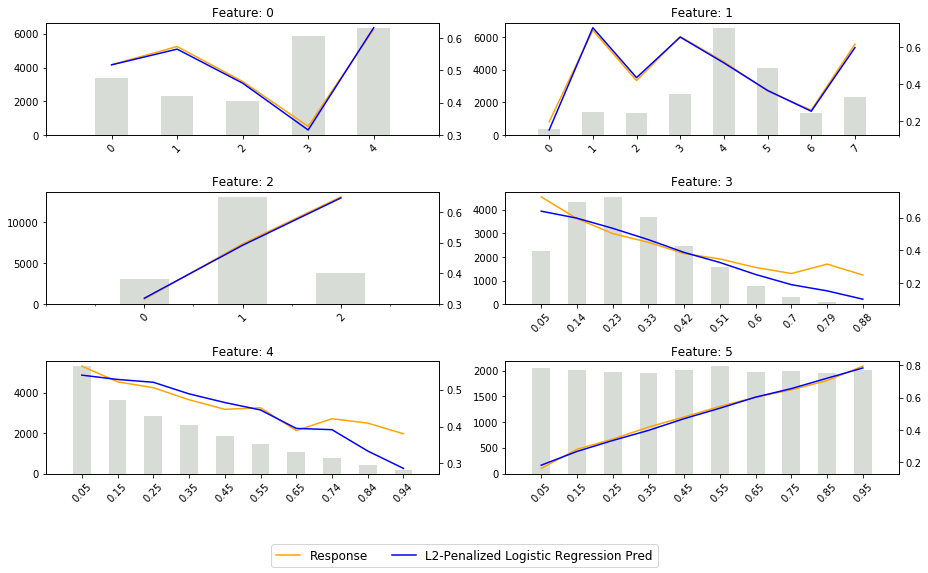

In [8]:
test['L2-Penalized Logistic Regression Pred'] = L2_LogisticRegression_preds[:,1]
newfig = plotData(test[x.featureNames + ['Response','L2-Penalized Logistic Regression Pred']],
                  ['Response','L2-Penalized Logistic Regression Pred'])

### Measuring Goodness of Fit - Receiver Operating Characteristic, AUC, Brier Score, Cumulative Gains Chart and Lift Chart

There are a plethora of metrics for evaluating the predictive power of a binary classifier. In this notebook I consider two of the most common measures: the Area Under the Receiver Operating Characteristic Curve (AUC) and the Brier Score. I also create plots of the Receiver Operating Characteristic Curve (ROC Curve), the Cumulative Gains Chart and the Lift Chart. Because I will be keeping this exposition short, I recommend reading the Wikipedia pages for these concepts. For each of the binary classifiers we consider here and each observation $i$ in the dataset, the classifier generates a score, $\hat{p}_i$, corresponding to the predicted probability that the observation is of class 1. For a given threshold value $p \in \left[0,1\right]$, one can define:
1. The True Positive Rate: The ratio of the total number of observations in the dataset that are of class 1 and have $\hat{p}_i > p$ to the total number of class 1 observations:
$$TPR(p) = \frac{\sum_{i=1}^N \mathbb{1}\left( \hat{p}_i > p \right) \mathbb{1}\left( y_i = 1 \right)}{\sum_{i=1}^N \mathbb{1}\left( y_i = 1 \right)}$$
2. The False Positive Rate: The ratio of the total number of observations in the dataset that are of class 0 and have $\hat{p}_i > p$ to the total number of class 0 observations:
$$FPR(p) = \frac{\sum_{i=1}^N \mathbb{1}\left( \hat{p}_i > p \right) \mathbb{1}\left( y_i = 0 \right)}{\sum_{i=1}^N \mathbb{1}\left( y_i = 0 \right)}$$
3. Gain: The ratio of the total number of observations of class 1 in the proportion $p$ of the dataset with highest values of $\hat{p}_i$ to the total number of observations of class 1 in the full dataset. Defining $R_i$ as the rank of observation $i$ according to $\hat{p}_i$:
$$G(p) = \frac{\sum_{i=1}^N \mathbb{1}\left( R_i >= pN \right) \mathbb{1}\left( y_i = 1 \right)}{\sum_{i=1}^N \mathbb{1}\left( y_i = 1 \right)}$$

The Receiver Operating Characteristic Curve is the plot of $\left(FPR(p), TPR(p) \right)$ for $p \in \left[0,1\right]$. Intuitively, for a given value of $p$, the higher the True Positive Rate and the lower the False Positive Rate, the better the classifier. Hence, for a given value of $p$, the distance from the x-axis to the ROC Curve can be used as an objective measure of the quality of the classifier. The AUC is the area under the ROC curve; i.e. the average of the distance from the x-axis to the ROC Curve over $p$.

The Cumulative Gains Chart is the plot of $\left(p, G(p) \right)$ for $p \in \left[0,1\right]$. If one were to take the proportion $p$ of the dataset with the highest predicted probability of being class 1, one would expect it to contain proportion $G(p)$ of all true class 1 observations in the full dataset.

The Lift Chart is the plot of $\left(p, {G(p)\over p} \right)$  for $p \in \left[0,1\right]$. This chart simply expresses the same information as the Cumulative Gains Chart but in a multiplicative form rather than proportional form.

Final, the Brier Score is defined as
$$BS = {1\over N}\sum_{i=1}^N \left( y_i - \hat{p}_i \right)^2$$

All else equal, classifiers with lower Brier Scores are better.

Again, if you would like more background on these charts and metrics, see their corresponding Wikipedia pages.

I plot the ROC Curve, Cumulative Gains Chart and Lift Chart, along with calculating the AUC and Brier Score, for the logistic model using the test dataset:

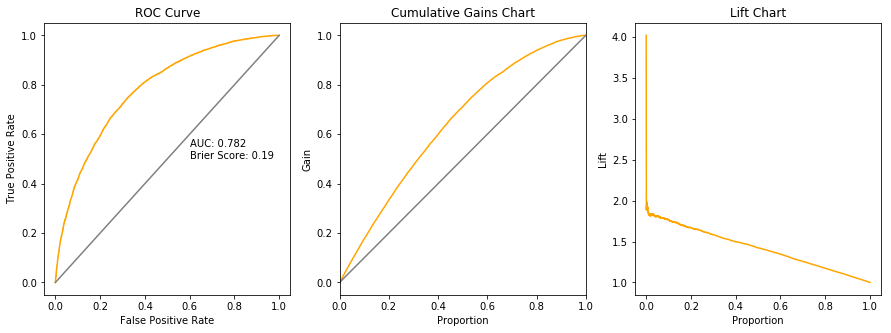

In [10]:
fpr_LR, tpr_LR, thresholds_LR = roc_curve(test.Response, test['L2-Penalized Logistic Regression Pred'])
AUC_LR = roc_auc_score(test.Response, test['L2-Penalized Logistic Regression Pred'])
BrierScore_LogisticRegression = brier_score_loss(test.Response, test['L2-Penalized Logistic Regression Pred'])
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].plot(fpr_LR,tpr_LR, color = 'orange')
axes[0].plot(np.array([0,1]),np.array([0,1]), color = 'grey')
axes[0].text(.6,.5,'AUC: {0}\nBrier Score: {1}'.format(round(AUC_LR,3),
                                                       round(BrierScore_LogisticRegression,3)))
axes[0].set_title('ROC Curve'); axes[0].set_xlabel('False Positive Rate'); axes[0].set_ylabel('True Positive Rate')

L2_LogisticRegressionGain = ((test[['Response','L2-Penalized Logistic Regression Pred']]
 .sort_values('L2-Penalized Logistic Regression Pred', ascending = False)
 .reset_index().Response.cumsum())/test.Response.sum())
L2_LogisticRegressionGain.index = L2_LogisticRegressionGain.index/L2_LogisticRegressionGain.shape[0]
L2_LogisticRegressionGain.plot(ax=axes[1], color = 'orange')
axes[1].plot(np.array([0,1]),np.array([0,1]), color = 'grey')
axes[1].set_title('Cumulative Gains Chart'); axes[1].set_xlabel('Proportion'); axes[1].set_ylabel('Gain')
axes[2].plot(L2_LogisticRegressionGain.index,
             L2_LogisticRegressionGain / L2_LogisticRegressionGain.index,color = 'orange')
axes[2].set_title('Lift Chart'); axes[2].set_xlabel('Proportion'); axes[2].set_ylabel('Lift')

### Gradient Boosting Machine (GBM)

The second machine learning classifier we will consider is gradient boosted trees. Leo Breiman, a pioneer in tree-based machine learning at U.C. Berkeley, has called gradient boosting, and specifically AdaBoost, the 'best off-the-shelf classifier in the world'. In my experience, it can be quite hard to beat a well-tuned GBM and the spate of Kaggle competitions won by GBMs further attest to their power. If you are familiar with classical gradient descent algorithms in mathematical optimization theory, the intuition behind GBM will be familiar. The following is a brief introduction to the idea of gradient boosting.

Given $N$ observations $\{y_i,x_i\}_{i=1}^{N}$, a class of predictor functions $F$, and a loss function $L$, the objective is to 
solve $$\underset{f \in F}{argmin}\sum\limits_{i=1}^N L(y_i, f(x_i))$$

In the case of gradient boosting, attention is restricted to the class of functions $F$ which can be written as the finite sum of weak learners from a given set of weak learners, typically decision trees. Gradient boosting then attempts to solve this problem iteratively.
At iteration $k+1$ we have an approximate solution $f_k$
from the previous iteration and we look to find a function $\eta_{k+1}$ such that the new approximate solution is
$f_{k+1}=f_k+\eta_{k+1}$. Let $\vec{f}_k$ be the $N$ x $1$ vector defined by $\vec{f}_{k,i} = f_k(x_i)$ and
let $\vec{\eta}$ also be an $N$ x $1$ vector. The derivative of the expression
$$\sum\limits_{i=1}^N L(y_i, \vec{f}_{k,i} + \vec{\eta}_{i})$$ with respect to $\vec{\eta}$, evaluated at
$\vec{\eta} = \vec{0}$, is an $N$ x $1$ vector, $\vec{\epsilon_{k+1}}$,
with $i^{th}$ element equal to $L_2(y_i, \vec{f}_{k,i})$. Regarding the objective function as a function of $\vec{\eta}$,
the direction of steepest descent is $-\vec{\epsilon_{k+1}}$, i.e. the negative of the gradient.
Gradient boosting takes $-\vec{\epsilon_{k+1}}$ as the target and fits a weak learner to it using $\vec{x}$ as predictors.
Calling this weak learner $\eta_{k+1}$, we set $f_{k+1} = f_k + \gamma\eta_{k+1}$, where $\gamma \in (0,1]$ is the learning rate.
We then continue to the next iteration. After $K$ iterations, the process is stopped,
yielding a final gradient boosting estimator $f_K$.

Fitting a GBM classifier in python requires only a few lines of code. Practitioners often use a procedure called cross validation to choose optimal values of the tuning parameters: the number of weak learners, the learning rate and, in the case of trees, the depth of the trees. To keep this example simple, we will skip tuning and just use 'reasonable' (read arbitrary) values for these parameters. I encourage the reader to try modifying the code below to incorporate parameter tuning.

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

GBM = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1,
    max_depth=1, random_state=0, subsample = 0.75).fit(X_train_scaled.values, Y_train.values)

Again, I plot average actual and predicted responses by feature using the test dataset: 

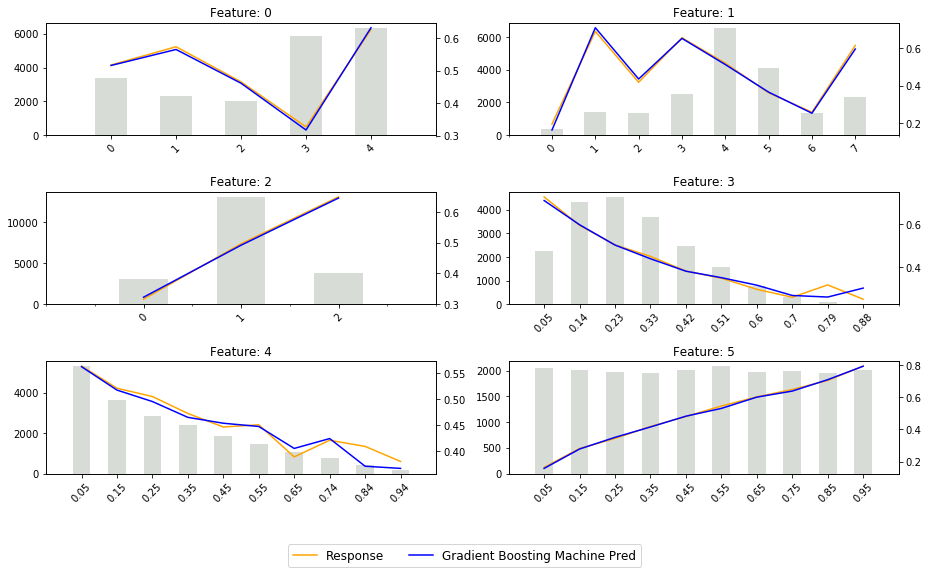

In [12]:
test['Gradient Boosting Machine Pred'] = GBM.predict_proba(X_test_scaled.values)[:,1]
newfig = plotData(test[x.featureNames + ['Response','Gradient Boosting Machine Pred']],
                  ['Response','Gradient Boosting Machine Pred'])

The first plot below shows the improvement in fit of the GBM, as measured by deviance reduction on both the train and test sets, across successive boosting iterations. Notice that the deviance on the train set decreases significantly more than the deviance on the test set - this is a result of the GBM's tendency to overfit the training data.

The second plot shows the relative importance of the features in the GBM. For a given decision tree, the relative importance of the features is calculated as the number of samples split by each feature normalized to sum to one. The relative importance of the features in the GBM is the average of the relative importances of the features across the trees that comprise the GBM.

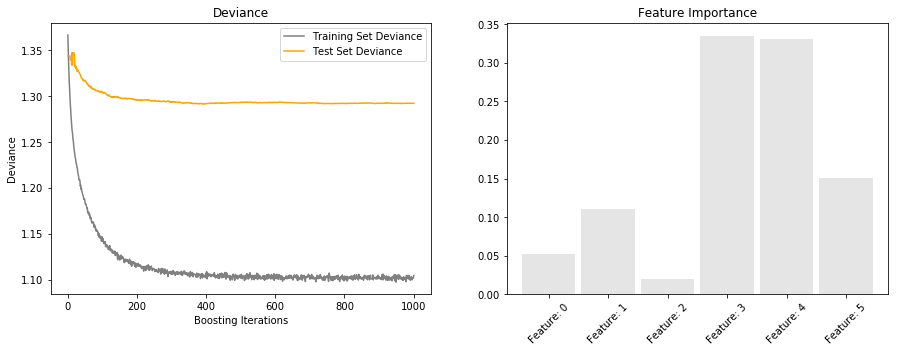

In [13]:
# compute test set deviance
test_score = np.zeros((GBM.n_estimators,), dtype=np.float64)

for i, y_pred in enumerate(GBM.staged_predict(X_test_scaled.values)):
    test_score[i] = GBM.loss_(Y_test.values, y_pred)

fig, axes = plt.subplots(1,2,figsize=(15,5))
    
axes[0].set_title('Deviance')
axes[0].plot(np.arange(GBM.n_estimators) + 1, GBM.train_score_, color = 'grey',
         label='Training Set Deviance')
axes[0].plot(np.arange(GBM.n_estimators) + 1, test_score, color = 'orange',
         label='Test Set Deviance')
axes[0].legend(loc='best')
axes[0].set_xlabel('Boosting Iterations')
axes[0].set_ylabel('Deviance')

FeatureImportance = pd.DataFrame({'Feature':[i.split(' Level')[0] for i in X_train.columns.tolist()],
                                 'Importance':GBM.feature_importances_}).groupby('Feature').sum()
FeatureImportance.plot(kind='bar', ax = axes[1], color='grey', alpha = 0.2,
                       legend = False, edgecolor = 'grey', lw = '0', width = 0.9)
axes[1].set_xlabel(''); axes[1].set_title('Feature Importance')
for tk in axes[1].get_xticklabels():
    tk.set_rotation(45)

Once again, I calculate the AUC and Brier Score and plot the ROC Curve, Cumulative Gains Chart and Lift Chart:

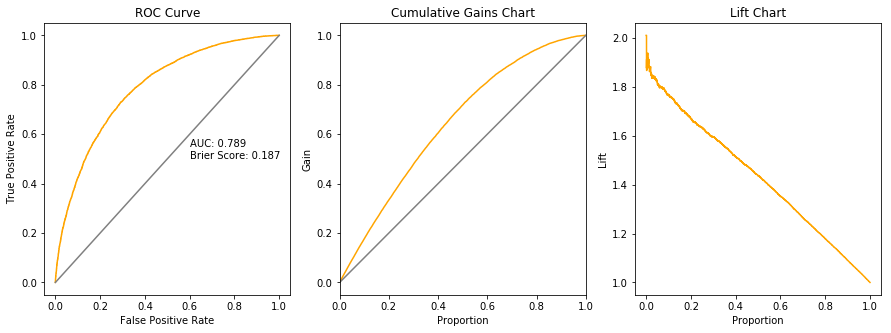

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(test.Response, test['Gradient Boosting Machine Pred'])
AUC_GBM = roc_auc_score(test.Response, test['Gradient Boosting Machine Pred'])
BrierScore_GBM = brier_score_loss(test.Response, test['Gradient Boosting Machine Pred'])
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].plot(fpr,tpr, color = 'orange')
axes[0].plot(np.array([0,1]),np.array([0,1]), color = 'grey')
axes[0].text(.6,.5,'AUC: {0}\nBrier Score: {1}'.format(round(AUC_GBM,3),round(BrierScore_GBM,3)))
axes[0].set_title('ROC Curve'); axes[0].set_xlabel('False Positive Rate'); axes[0].set_ylabel('True Positive Rate')

GBMGain = ((test[['Response','Gradient Boosting Machine Pred']]
 .sort_values('Gradient Boosting Machine Pred', ascending = False)
 .reset_index().Response.cumsum())/test.Response.sum())
GBMGain.index = GBMGain.index/GBMGain.shape[0]
GBMGain.plot(ax=axes[1], color = 'orange')
axes[1].plot(np.array([0,1]),np.array([0,1]), color = 'grey')
axes[1].set_title('Cumulative Gains Chart'); axes[1].set_xlabel('Proportion'); axes[1].set_ylabel('Gain')
axes[2].plot(GBMGain.index,
             GBMGain / GBMGain.index,color = 'orange')
axes[2].set_title('Lift Chart'); axes[2].set_xlabel('Proportion'); axes[2].set_ylabel('Lift')

## Feed Forward Neural Network

The final machine learning model we will consider is an artificial neural network. To keep the exposition basic, I consider the simplest network architecture; a fully connected feed forward neural network. The network has an input layer, two hidden layers and an output layer. The hidden layers will have 32 and 8 neurons respectively:

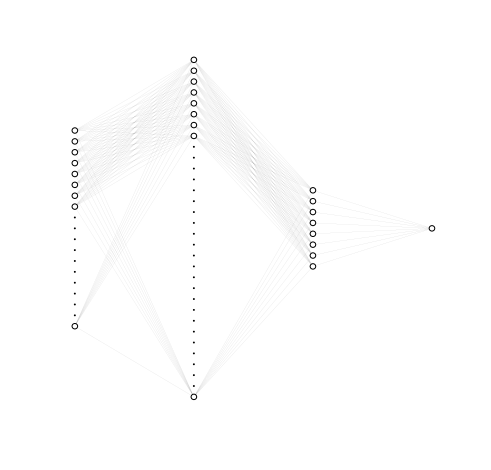

In [15]:
import draw_neural_net
reload(draw_neural_net)
from draw_neural_net import draw_neural_net
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [X_train_scaled.shape[1], 32, 8, 1])
fig.show()

I use the keras package with Google's TensorFlow:

In [16]:
# Using keras with TensorFlow backend
import keras
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


In [17]:
inputs = Input(shape = (X_train_scaled.shape[1],))
Layer1 = Dense(32,activation = 'sigmoid')(inputs)
Layer2 = Dense(8, activation = 'sigmoid')(Layer1)
out = Dense(1, activation = 'sigmoid')(Layer2)
FFNN = Model(inputs, out)
FFNN.compile(loss='binary_crossentropy',optimizer='adam')

FFNN.fit(X_train_scaled.values,Y_train.values,
          epochs=200, batch_size=1000, verbose=0)

Again I plot the average response and prediction by feature:

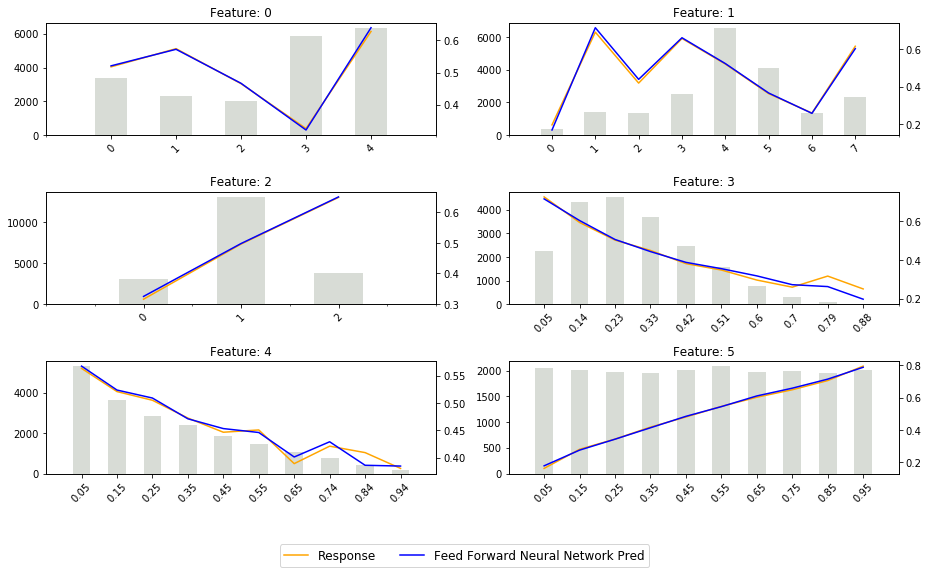

In [18]:
test['Feed Forward Neural Network Pred'] = FFNN.predict(X_test_scaled.values)
newfig = plotData(test[x.featureNames + ['Response','Feed Forward Neural Network Pred']],
                  ['Response','Feed Forward Neural Network Pred'])

As before, the AUC, Brier Score, ROC Curve, Cumulative Gains Curve and Lift Chart on the test dataset:

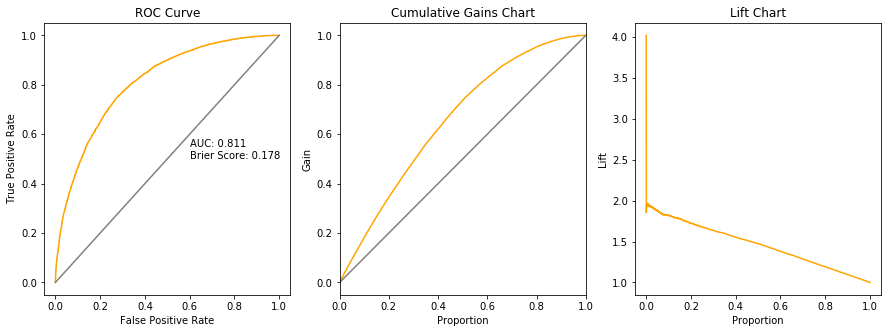

In [19]:
fpr, tpr, thresholds = roc_curve(test.Response, test['Feed Forward Neural Network Pred'])
AUC_FFNN = roc_auc_score(test.Response, test['Feed Forward Neural Network Pred'])
BrierScore_FFNN = brier_score_loss(test.Response, test['Feed Forward Neural Network Pred'])
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].plot(fpr,tpr, color = 'orange')
axes[0].plot(np.array([0,1]),np.array([0,1]), color = 'grey')
axes[0].text(.6,.5,'AUC: {0}\nBrier Score: {1}'.format(round(AUC_FFNN,3),round(BrierScore_FFNN,3)))
axes[0].set_title('ROC Curve'); axes[0].set_xlabel('False Positive Rate'); axes[0].set_ylabel('True Positive Rate')

FFNNGain = ((test[['Response','Feed Forward Neural Network Pred']]
 .sort_values('Feed Forward Neural Network Pred', ascending = False)
 .reset_index().Response.cumsum())/test.Response.sum())
FFNNGain.index = FFNNGain.index/FFNNGain.shape[0]
FFNNGain.plot(ax=axes[1], color = 'orange')
axes[1].plot(np.array([0,1]),np.array([0,1]), color = 'grey')
axes[1].set_title('Cumulative Gains Chart'); axes[1].set_xlabel('Proportion'); axes[1].set_ylabel('Gain')
axes[2].plot(FFNNGain.index,
             FFNNGain / FFNNGain.index,color = 'orange')
axes[2].set_title('Lift Chart'); axes[2].set_xlabel('Proportion'); axes[2].set_ylabel('Lift')

## Final Model Selection

I select the final model from the three choices above based on the Brier Score on the validation dataset. Note that I have not used the validation set up until this point; I recommend this approach as a best practice.

In [20]:
BrierScore_LogisticRegression_Val = brier_score_loss(Y_validate,
                                                     L2_LogisticRegression.predict_proba(X_validate_scaled.values)[:,1])
BrierScore_GBM_Val = brier_score_loss(Y_validate, GBM.predict_proba(X_validate_scaled.values)[:,1])
BrierScore_FFNN_Val = brier_score_loss(Y_validate, FFNN.predict(X_validate_scaled.values))

print('\n','Brier Score for L1-Penalized Logistic Regression: ', BrierScore_LogisticRegression_Val,'\n',
     'Brier Score for Gradient Boosting Machine: ', BrierScore_GBM_Val, '\n',
     'Brier Score for Feed Forward Neural Network: ',BrierScore_FFNN_Val)


 Brier Score for L1-Penalized Logistic Regression:  0.190294552378 
 Brier Score for Gradient Boosting Machine:  0.187256868049 
 Brier Score for Feed Forward Neural Network:  0.176701668304


Based on the Brier Score, the Feed Forward Neural Network is chosen. To learn more about these three models (and many more), I recommend exploring the references on their Wikipedia pages. Also consider checking out 'The Elements of Statistical Learning' by Trevor Hastie, Robert Tibshirani and Jerome Friedman - the authors provide a free pdf version online.